<a href="https://colab.research.google.com/github/sergiopdl/k_arm_bandit/blob/main/K_armBanditV3_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#RL Simulations
Based on Chapter 2 of Sutton and Barto 2020


##Imports

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

## Environment Class
Class & methods for:
- Defining the expected reward distribution
- Playing a bandit (interacting with the environment)

In [ ]:
class Environment:

  def __init__(self, mean=0, sd=1, k_arms=10, scale_factor=1):

    # Mean of distribution to draw reward samples from
    self.mean = mean
    
    # Standard deviation to draw reward samples from
    self.sd = sd

    # Number of arms per bandit
    self.k_arms = k_arms

    # List of expected rewards (per arm) to draw samples from
    self.mean_rewards = np.random.normal(mean, sd, k_arms)

    # Factor for scaling the reward samples
    self.scale_factor = scale_factor
  
  def play_bandit(self, action):
    """
    Returns a sample reward for a given action from a corresponding normal distribution
    """
    return np.random.normal(self.mean_rewards[action] * self.scale_factor, self.sd)

  def plot_samples(self, num_samples=200):
    """
    Plot the distribution of rewards that are sampled
    """
    samples_per_arm = np.zeros((num_samples, self.k_arms))

    for action in range(self.k_arms):
      for sample in range(num_samples):
        samples_per_arm[sample, action] = self.play_bandit(action)  

    plt.violinplot(samples_per_arm);

##Agent Class
Class & methods for:
- Choosing an action
- Maintaining the Q table of estimated rewards

In [ ]:
class Agent:

  def __init__(self, epsilon, k_arms):

    # List of estimated rewards (per arm)
    self.Q_table = np.zeros(k_arms)                     

    # Running counts for sample-average method
    self.sum_rewards_per_arm = np.zeros(k_arms)
    self.num_pulls_per_arm = np.zeros(k_arms)

    # Parameter for exploring vs. exploiting
    self.epsilon = epsilon        

  def reset(self, k_arms):
    """
    Reset Q table and running counts when simulating multiple agents
    """
    self.Q_table = np.zeros(k_arms)                     
    self.sum_rewards_per_arm = np.zeros(k_arms)
    self.num_pulls_per_arm = np.zeros(k_arms)  
    
  def choose_action(self):
    """
    Returns an action randomly or based on max expected reward
    """
    probability = np.random.random()

    # Explore
    if probability < self.epsilon:
      return np.random.randint(len(self.Q_table))

    # Exploit
    else:
      return np.argmax(self.Q_table)                                            

  def sample_average_update(self, action, reward):
    """
    Updates the Q table based on the "sample-average" method from RLbook eq. 2.1 on page 27
    """
    self.num_pulls_per_arm[action] += 1
    self.sum_rewards_per_arm[action] += reward
    self.Q_table[action] = self.sum_rewards_per_arm[action] / self.num_pulls_per_arm[action]
  
  def incremental_update(self, action, reward, timestep):
    """
    Updates the Q table based on the "incremental" implementation from RLbook eq. 2.3
    """
    self.Q_table[action] += 1/(timestep+1) * (reward-self.Q_table[action])

## Simulation Class
Class & method for running multiple timesteps and bandits

In [ ]:
class Simulation:

  def __init__(self, env, epsilon=0.1, update_method='sample-average', num_bandits=200, num_timesteps=1000):
    
    # Store initial env passed in
    self.env = env

    # Initialize an agent
    self.agent = Agent(epsilon, self.env.k_arms)                                                 

    # Sample-average vs. incremental
    self.update_method = update_method

    # Store simulation parameters
    self.num_bandits = num_bandits
    self.num_timesteps = num_timesteps

    # Used for Figure 2.2 from RL book page 29
    self.average_rewards = np.zeros(self.num_timesteps)

    # Used for Figure 2.2 from RL book page 29
    self.percent_optimal_action = np.zeros(self.num_timesteps)

  def run(self, show_bar_plot=False):
    """
    Run the simluation based on the indicated update method and corresponding number of test bandits & timesteps
    """
    for bandit in range(self.num_bandits):

      # To compute average rewards and % optimal actions over time
      reward_history = np.zeros(self.num_timesteps)
      optimal_action_history = np.zeros(self.num_timesteps)

      for timestep in range(self.num_timesteps):

        # Show plot every X timesteps
        if (show_bar_plot and timestep % 100 == 0):
          print("Value estimates at iteration: ", timestep)
          plt.bar(range(self.env.k_arms), self.agent.Q_table)
          plt.show()

        # Determine which arm to pull
        action = self.agent.choose_action()
        
        # Log optimal action
        if action == np.argmax(self.env.mean_rewards):
          optimal_action_history[timestep] += 1

        # Pull arm and log the reward value
        reward = self.env.play_bandit(action)
        reward_history[timestep] = reward

        # Update the agent's Q table
        if self.update_method == "sample-average":
          self.agent.sample_average_update(action, reward)   
        elif self.update_method == "incremental":
          self.agent.incremental_update(action, reward, timestep)

      # Add this loop's rewards and optimal actions to running sums
      self.average_rewards += reward_history
      self.percent_optimal_action += optimal_action_history

      # Reset agent's Q table and running counts for each bandit problem
      self.agent.reset(self.env.k_arms)

      # Spin up a new env for each bandit problem
      self.env = Environment(self.env.mean, self.env.sd, self.env.k_arms, self.env.scale_factor)                                              

    # Compute the final average rewards and % optimal actions
    self.average_rewards /= self.num_bandits
    self.percent_optimal_action /= self.num_bandits

  def plot_average_reward(self):
    """
    Plot a line chart of average reward for each agent (for all bandit problems) at each timestep 
    """
    plt.plot(range(self.num_timesteps), self.average_rewards, label = str(self.agent.epsilon))
    plt.legend()

  def plot_optimal_action(self):
    """
    Plot a line chart of percent of optimal action for each agent (for all bandit problems) at each timestep 
    """
    plt.plot(range(self.num_timesteps), self.percent_optimal_action, label = str(self.agent.epsilon))
    plt.legend()

##Create a bandit (env) and plot the distribution of samples

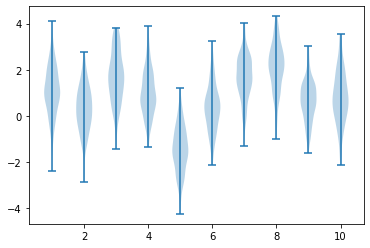

In [ ]:
env = Environment(mean=0, sd=1, k_arms=10, scale_factor=1)
env.plot_samples()

##Run and view a single agent's Q table over time
To compare to the distribution above

Value estimates at iteration:  0


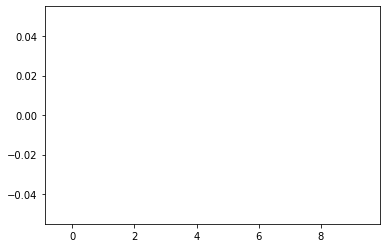

Value estimates at iteration:  100


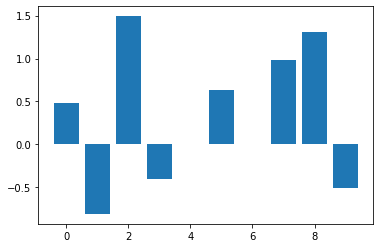

Value estimates at iteration:  200


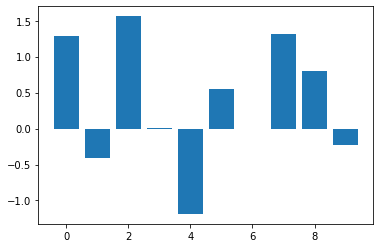

Value estimates at iteration:  300


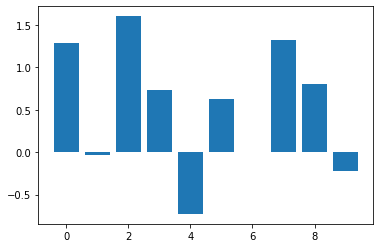

In [ ]:
sim = Simulation(env=env, epsilon=0.1, update_method='sample-average', num_bandits=1, num_timesteps=400)
sim.run(show_bar_plot = True)

##View average rewards and % of optimal actions over time for different policies

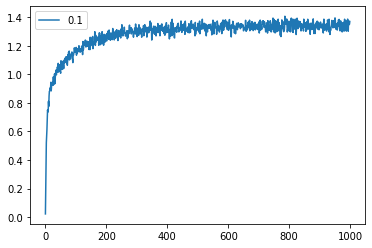

In [ ]:
sim = Simulation(env=env, epsilon=0.1, update_method='sample-average', num_bandits=2000, num_timesteps=1000)
sim.run(show_bar_plot = False)
sim.plot_average_reward()

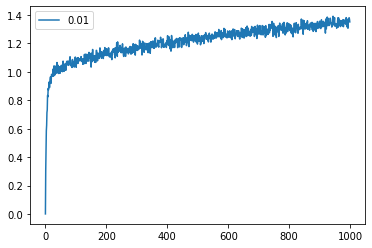

In [ ]:
sim2 = Simulation(env=env, epsilon=0.01, update_method='sample-average', num_bandits=2000, num_timesteps=1000)
sim2.run(show_bar_plot = False)
sim2.plot_average_reward() 

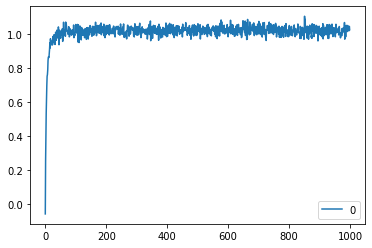

In [ ]:
sim3 = Simulation(env=env, epsilon=0, update_method='incremental', num_bandits=2000, num_timesteps=1000)
sim3.run(show_bar_plot = False)
sim3.plot_average_reward()

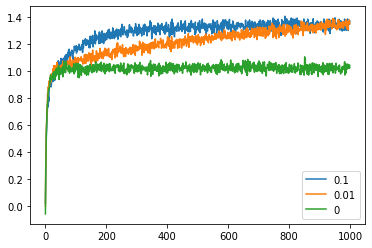

In [ ]:
sim.plot_average_reward()
sim2.plot_average_reward() 
sim3.plot_average_reward()

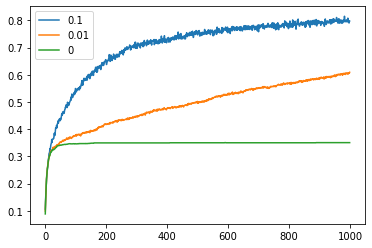

In [ ]:
sim.plot_optimal_action()
sim2.plot_optimal_action()
sim3.plot_optimal_action()